# Drawing an explanatory image for the paper
This section contains no material of interest to readers. It exists purely for drawing explanatory diagrams. 

In [1]:
from pyam import IamDataFrame
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from os.path import join
import scipy.interpolate

<IPython.core.display.Javascript object>

pyam - INFO: Running in a notebook, setting `pyam` logging level to `logging.INFO` and adding stderr handler


In [2]:
# We start by making example data
_msa = ["model_a", "scen_a"]
_msb = ["model_b", "scen_b"]
_msc = ["model_c", "scen_c"]
_co2 = "Emissions|CO2"
_ch4 = "Emissions|CH4"
db_dt = pd.DataFrame(
    [
        _msa + ["World", _co2, "", 1, 2, 2.5],
        _msb + ["World", _co2, "", 2.5, 3, 3.2],
        _msc + ["World", _co2, "", 1.8, 3, 3.2],
        _msa + ["World", _ch4, "", 0.5, 0.8, 1.25],
        _msb + ["World", _ch4, "", 0.75, 0.98, 1.1],
        _msc + ["World", _ch4, "", 0.6, 0.6, 0.75],
    ],
    columns=[
        "model", "scenario", "region", "variable", "unit", 2020, 2025, 2030
    ]
)
db_dt = IamDataFrame(db_dt)

In [3]:
db_dt_mod = db_dt.copy()
db_dt_mod["value"] = db_dt_mod["value"] * 1.5 - 0.5
db_dt_mod["scenario"] = db_dt_mod["scenario"] + "_"
db_dt_mod.append(db_dt, inplace=True)
db_dt_mod = IamDataFrame(db_dt_mod.data)

In [4]:
savefig_folder = "../output/"

In [5]:
yearlist = [int(year) for year in db_dt_mod["year"].unique()]

## Making the plots
### Scatter plot of emissions

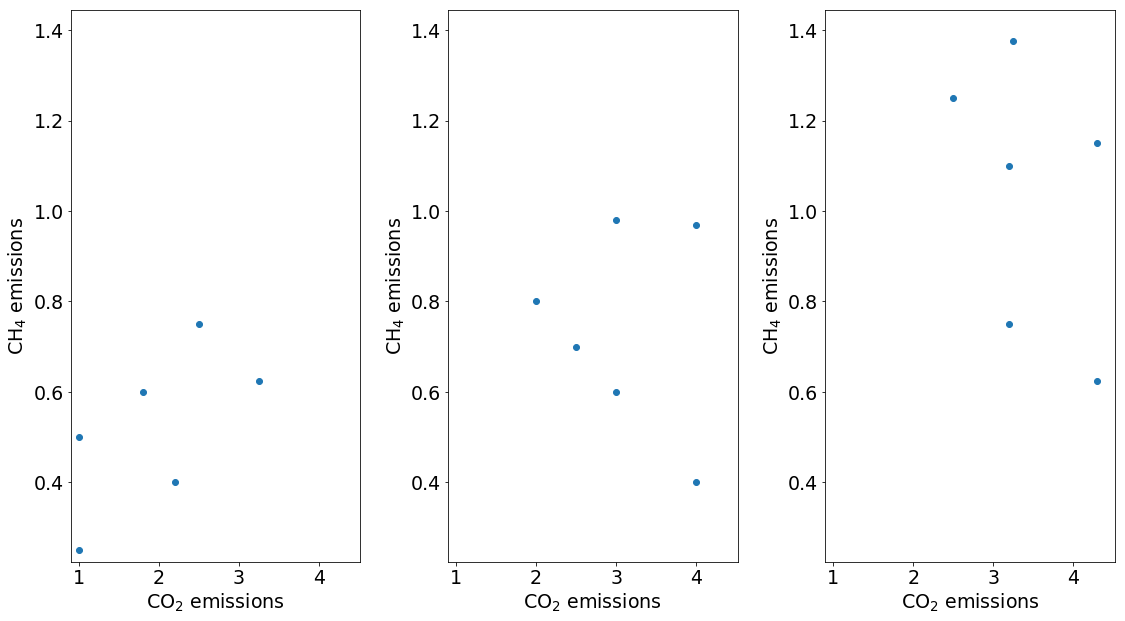

In [6]:
xlims = (
    min(db_dt_mod.filter(variable=_co2)["value"]) * 0.9, 
    max(db_dt_mod.filter(variable=_co2)["value"]) * 1.05
)
ylims = (
    min(db_dt_mod.filter(variable=_ch4)["value"]) * 0.9, 
    max(db_dt_mod.filter(variable=_ch4)["value"]) * 1.05
)
fig = plt.figure(figsize=(16, 9))
plt.rcParams.update({'font.size': 19})
for i, year in enumerate(yearlist):
    ax = fig.add_subplot(1, 3, i + 1)
    plt.scatter(
        db_dt_mod.filter(year=year, variable=_co2)["value"], 
        db_dt_mod.filter(year=year, variable=_ch4)["value"]
    )
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    ax.set_xlabel("CO$_2$ emissions")
    ax.set_ylabel("CH$_4$ emissions")
fig.tight_layout()
fig.savefig(
    join(savefig_folder, "CO2Methane3Decades.pdf"), 
    bbox_inches='tight'
)
plt.rcParams.update({'font.size': 14})

### Plotting the windows
This requires material for both the x-y relation and the weighting function

In [7]:
year = 2020
xs = db_dt_mod.filter(year=year, variable=_co2)["value"]

step = (max(xs) - min(xs)) / 200
window_width = (max(xs) - min(xs)) / 4
x_c = np.arange(min(xs), max(xs) + step / 2, step)
x_p = min(xs) + 2* window_width
def weight_fn(z):
    return 1/(1 + ((z - x_p) / window_width * 2) ** 2)
y = weight_fn(x_c)

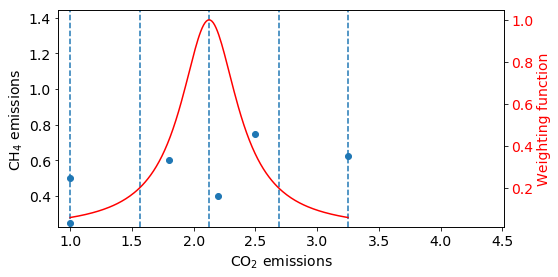

In [8]:
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(111)
plt.scatter(
    db_dt_mod.filter(year=year, variable=_co2)["value"], 
    db_dt_mod.filter(year=year, variable=_ch4)["value"]
)
for x in np.arange(min(xs), max(xs) + 0.1, (max(xs) - min(xs)) / 4):
    plt.axvline(x=x, ls="--")
ax2 = ax.twinx()
ax2.plot(x_c, y, c="r")
ax2.tick_params(axis='y', labelcolor="r")
ax.set_xlim(xlims)
ax.set_ylim(ylims)
ax.set_xlabel("CO$_2$ emissions")
ax.set_ylabel("CH$_4$ emissions")
ax2.set_ylabel("Weighting function", color="r")
fig.savefig(
    join(savefig_folder, "CO2MethaneDottedLine.pdf"), 
    bbox_inches='tight'
)

### Plotting the cumulative weight vs follow gas

In [9]:
xs = db_dt_mod.filter(variable=_co2, year=year)["value"]
ys = db_dt_mod.filter(variable=_ch4, year=year)["value"]
ys, xs = map(np.array, zip(*sorted(zip(ys, xs))))
ys

array([0.25 , 0.4  , 0.5  , 0.6  , 0.625, 0.75 ])

In [10]:
weights = weight_fn(ys)
weights = weights / sum(weights)
cumsum_w = np.cumsum(weights) - 0.5 * weights

In [11]:
y_ans = scipy.interpolate.interp1d(
    cumsum_w, ys, bounds_error=False, fill_value=(ys[0], ys[-1]), assume_sorted=True
)(0.5)
y_ans

array(0.5953804)

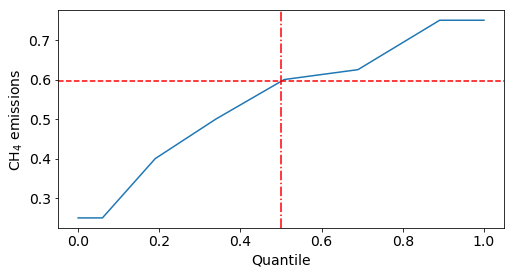

In [12]:
y_xtend = np.append(ys[0], np.append(ys, ys[-1]))
cumsum_w_xtend = np.append(0, np.append(np.cumsum(weights) - 0.5 * weights, 1))
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(111)
plt.plot(cumsum_w_xtend, y_xtend)
ax.set_xlabel("Quantile")
ax.set_ylabel("CH$_4$ emissions")
plt.axvline(x=0.5, ls="-.", c="r")
plt.axhline(y=y_ans, ls="--", c="r")
fig.savefig(
    join(savefig_folder, "CumulWeightCH4.pdf"), 
    bbox_inches='tight'
)


In [13]:
np.exp(np.log(0.5)/100)

0.9930924954370359